# [DST-50] Скоринговая модель предсказания дефолта клиентов

## 0. Подготовка к работе
Загружаем необходимые библиотеки, читаем данные для обучения и предсказания, бегло смотрим на состав и качество данных

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
RND_STATE = 73 # ensure results are reproducible

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
path = '/kaggle/input/sf-dst-scoring/'

In [3]:
train = pd.read_csv(path +'/train.csv')
test = pd.read_csv(path +'test.csv')

**Тренировочная выборка:**

In [4]:
print(train.info())
print('Train size: ', train.shape)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Мы располагаем следующей информацией из анкетных данных заемщиков:

* `client_id` - идентификатор клиента,
* `education` - уровень образования,
* `sex` - пол заемщика,
* `age` - возраст заемщика,
* `car` - флаг наличия автомобиля,
* `car_type` - флаг автомобиля иномарки,
* `decline_app_cnt` - количество отказанных прошлых заявок,
* `good_work` - флаг наличия "хорошей" работы,
* `bki_request_cnt` - количество запросов в БКИ,
* `home_address` - категоризатор домашнего адреса,
* `work_address` - категоризатор рабочего адреса,
* `income` - доход заемщика,
* `foreign_passport` - наличие загранпаспорта,
* `sna` - связь заемщика с клиентами банка,
* `first_time` - давность наличия информации о заемщике,
* `score_bki` - скоринговый балл по данным из БКИ,
* `region_rating` - рейтинг региона,
* `app_date` - дата подачи заявки,
* `default` - флаг дефолта по кредиту.

Данных много, пропусков мало, да и те только в столбце `education`. Целевой столбец - `default`. Посмотрим на распределение клиентов по целевому столбцу:

0    64427
1     9372
Name: default, dtype: int64
non-default 7 : 1 default


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


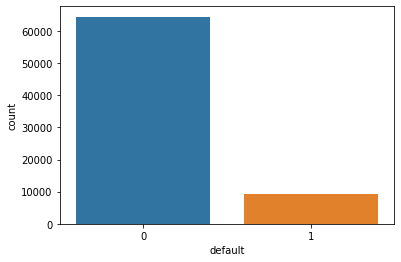

In [5]:
sns.countplot(train.default)
disp = train.default.value_counts()
print(disp)
print('non-default', round(disp[0] / disp[1]), ': 1', 'default')


Как видно из графика, распределение не очень-то сбалансировано, но отншение недефолтных клиентов к дефолтным всего 7 к 1, что является приемлемым и вроде бы не требует дальнейших манипуляций. Но вернемся к этому вопросу после получения предварительных результатов качества модели.

**Тестовая выборка:**

In [6]:
print(test.info())
print('Test size: ', train.shape)
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


Пропуски так же только в столбце `education`. 

## 1. EDA

Для дальнейшего удобства работы с данными объединим два дата-сета, пометив каждый из них дополнительным столбцом `test`. Также сразу избавимся от ненужного столбца `client_id`

In [7]:
test_client_id = test.client_id
train['test'] = 0   # train
test['test'] = 1    # test
test['default'] = -1  # imaginary value for now
data = pd.concat([train, test], ignore_index=True)
data.drop(columns='client_id', inplace=True)

Посмотрим на данные в других столбцах

In [8]:
data.drop(columns=['default', 'test']).nunique().sort_values()

foreign_passport         2
sex                      2
car                      2
car_type                 2
good_work                2
home_address             3
work_address             3
first_time               4
sna                      4
education                5
region_rating            7
decline_app_cnt         24
bki_request_cnt         40
age                     52
app_date               120
income                1207
score_bki           102618
dtype: int64

Присутствуют бинарные, категоральные и числовые признаки. Среди всех столбцов выделяется `app_date`. Он как бы строковый, но по сути - это дата актуализации данных по клиенту. Преобразуем для начала этот столбец в число равное "возрасту анкеты" - количеству дней между значением этого столбца для конкретного клиента и максимальным значением этого столбца.

In [9]:
app_date = pd.to_datetime(data.app_date)
max_app_date = app_date.max()
data.app_date = (max_app_date - app_date).dt.days

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='app_date', ylabel='count'>

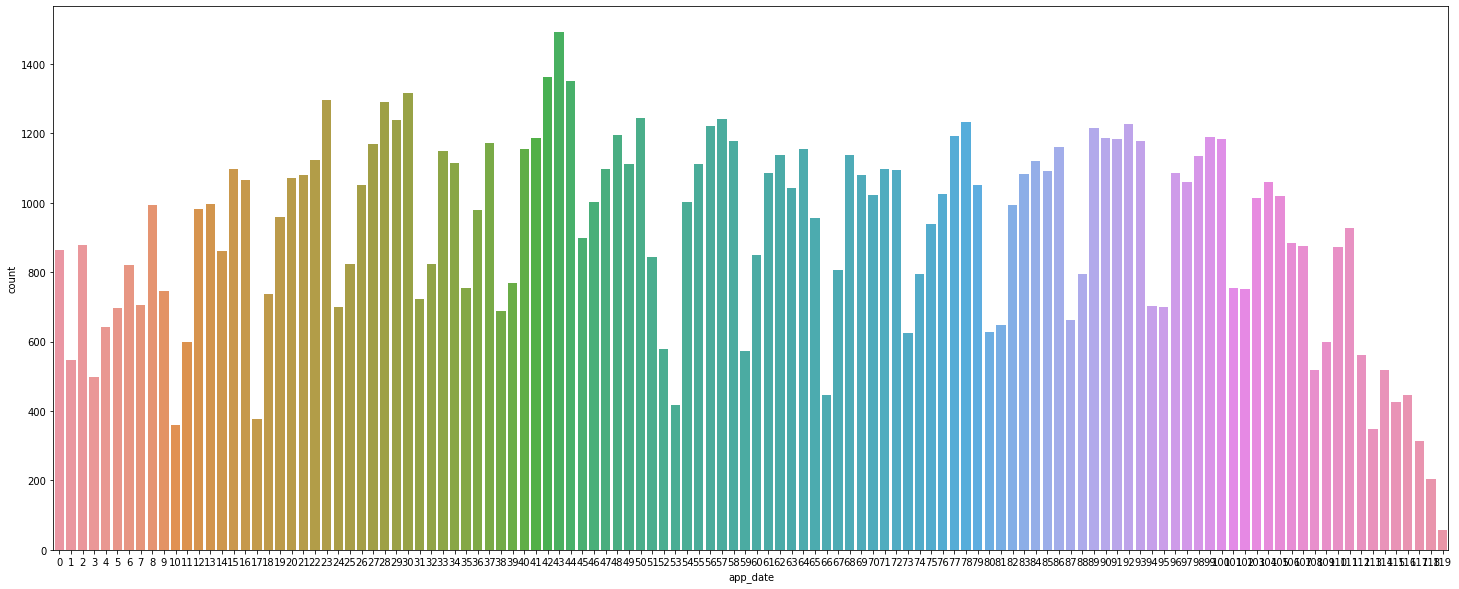

In [10]:
fig, axes = plt.subplots(figsize=(25,10))
sns.countplot(data.app_date, ax=axes)

Полученные значения достаточно равномерны, выбросов нет, ошибочных значений тоже. Теперь можно разбить выборку по типам признаков для простоты дальнейшего анализа.

In [11]:
num_cols = ['app_date', 'age','decline_app_cnt','score_bki','income','bki_request_cnt','region_rating', 'first_time'] 
cat_cols = ['education','work_address','home_address','sna'] 
bin_cols = ['sex','car','car_type','good_work','foreign_passport'] 

### Числовые переменные

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   app_date          110148 non-null  int64  
 1   education         109670 non-null  object 
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


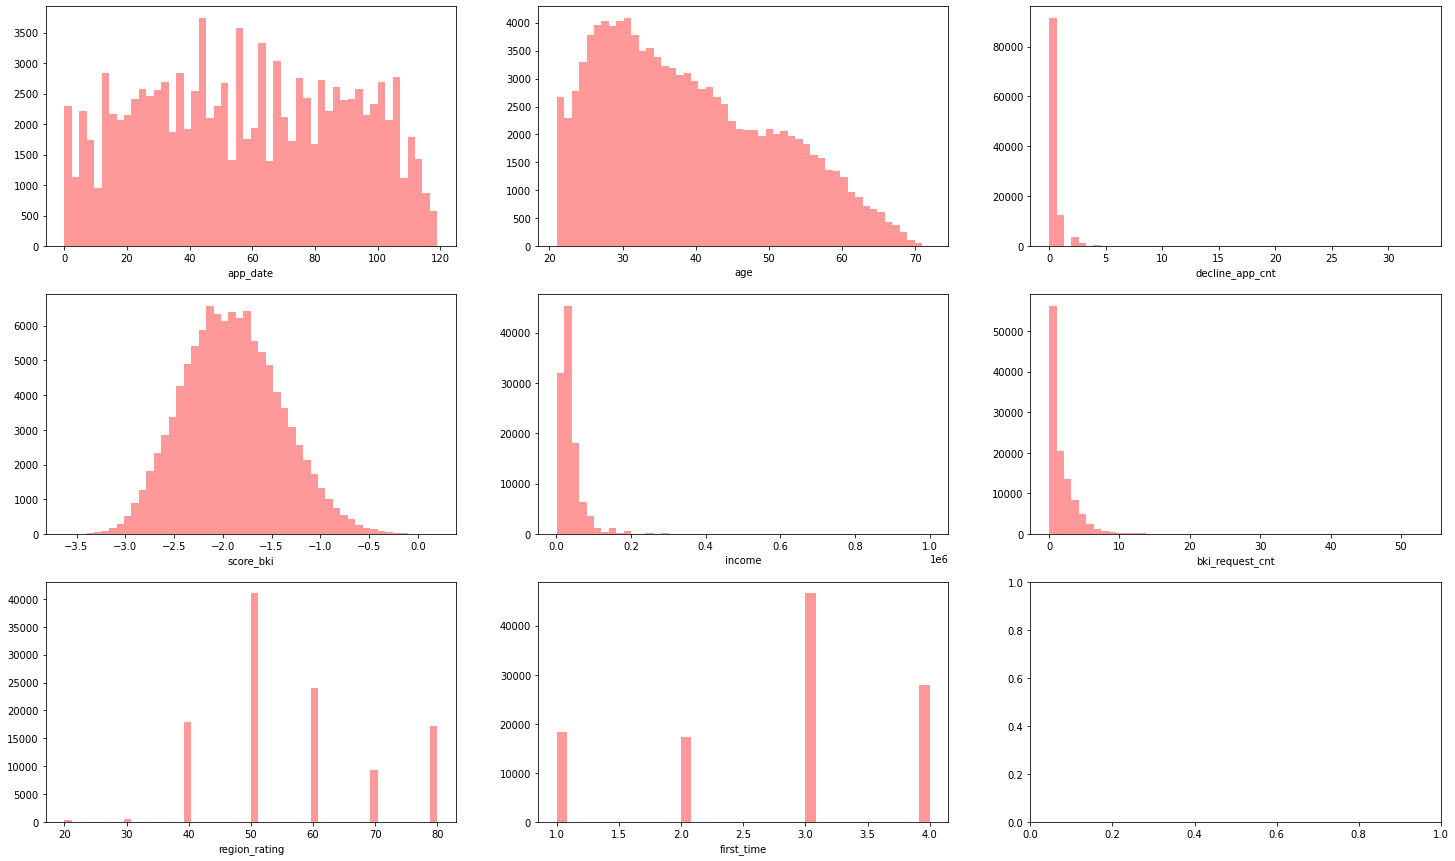

In [13]:
# Let's look at numerical data
fig, axes = plt.subplots(3, 3, figsize=(25,15))

for i,col in enumerate(num_cols):
    sns.distplot(data[col], kde=False, ax=axes.flat[i], color="r")

Столбцы `decline_app_cnt`, `income`, `bki_request_cnt` имеют ярко выраженное экспоненциальное распределение. Такие лучше сразу логарифмировать

In [14]:
for col in ['decline_app_cnt', 'income', 'bki_request_cnt']:
    data[col] = np.log(1 + data[col]) # add 1 to prevent taking log from zero

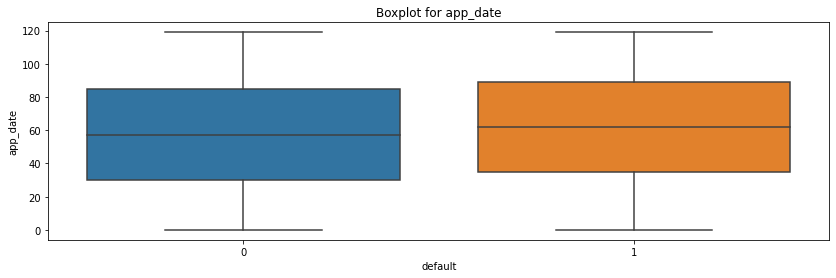

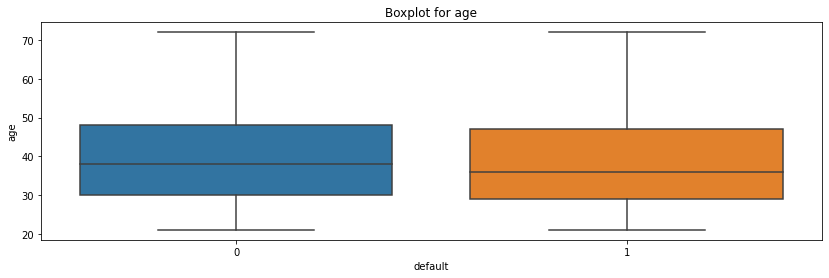

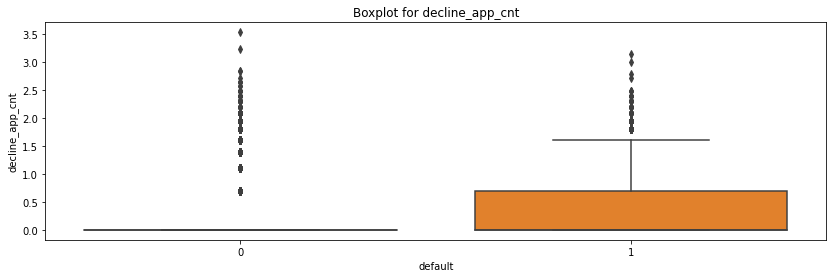

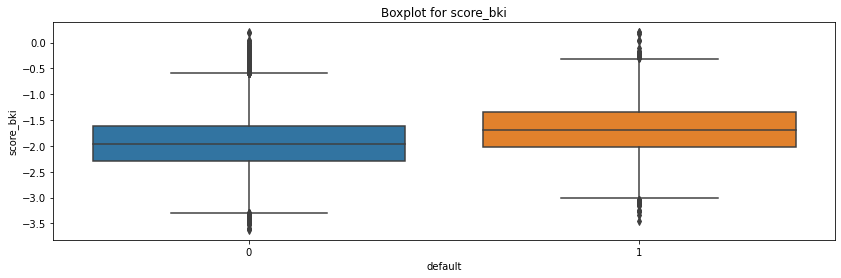

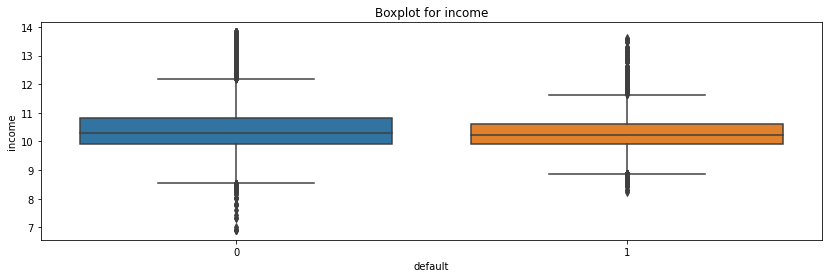

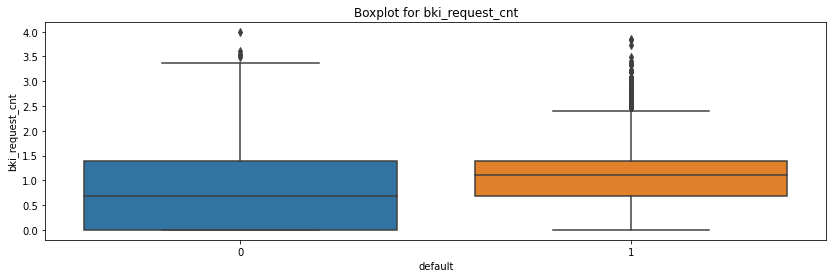

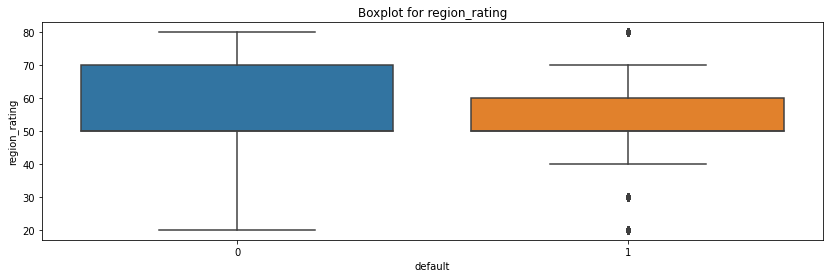

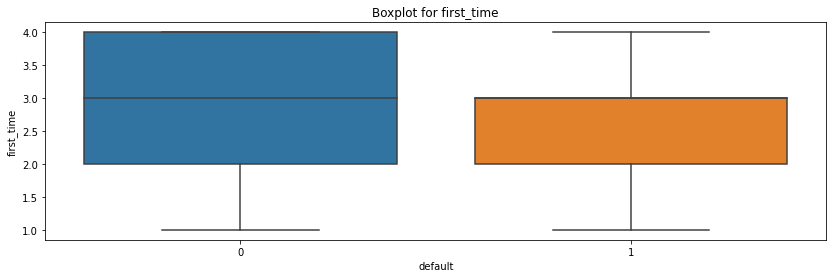

In [15]:
def draw_boxplot(col):
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=col, data=data[data['test'] == 0],ax=axes)
    axes.set_title('Boxplot for ' + col)
    plt.show()
for col in num_cols:
    draw_boxplot(col)

Видно, что
1. ненадежные клиенты в среднем моложе
2. bki_score выше у тех, кто просрачивает
3. невозвраты как-то связаны с регионом
4. запросов в БКИ больше у надежных клиентов
5. в среднем, более надежными клиентами являются более те, у кого доход выше

### Категоральные переменные

Начнем с образования. Как мы помним, в этом столбце есть пропуски, которые необходимо заполнить. Можно заполнить пропуски самым частым значением, а можно считать пропуски отсутствием образования. При отсутствии других вводных, я считаю, что менее рисковано приравнять пропуск к отсутствию образования.

<AxesSubplot:>

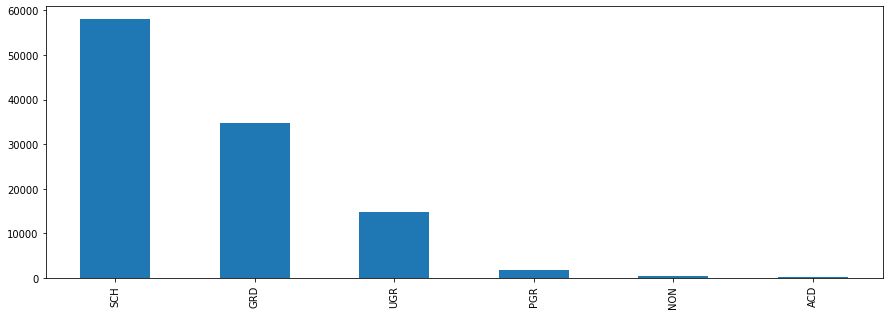

In [16]:
data.education.fillna('NON', inplace=True)
data.education.value_counts().plot(kind="bar",figsize=(15,5))

Т.к. очевидно, что уровни образования можно однозначно сортировать по возрастанию качества/ценности/значимости, то их необходимо преобразовать в числовые значения. `OneHotEncoder` для этой цели не подойдет, надо использовать `OrdinalEncoder`

In [17]:
oe = OrdinalEncoder(categories=[['NON', 'SCH', 'GRD', 'UGR', 'PGR', 'ACD']])
data[['education']] = oe.fit_transform(data[['education']])

In [18]:
for col in cat_cols[1:]:
    print('value counts for:', col)
    print(data[col].value_counts())

value counts for: work_address
3    67113
2    30761
1    12274
Name: work_address, dtype: int64
value counts for: home_address
2    59591
1    48688
3     1869
Name: home_address, dtype: int64
value counts for: sna
1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64


Видно, что данные вроде категоральные, но по факту число. выбросов нет, пропусков нет - пока трогать не будем.

### Бинарные переменные

In [19]:
for col in bin_cols:
    print('value counts for:', col)
    print(data[col].value_counts())

value counts for: sex
F    61836
M    48312
Name: sex, dtype: int64
value counts for: car
N    74290
Y    35858
Name: car, dtype: int64
value counts for: car_type
N    89140
Y    21008
Name: car_type, dtype: int64
value counts for: good_work
0    91917
1    18231
Name: good_work, dtype: int64
value counts for: foreign_passport
N    93721
Y    16427
Name: foreign_passport, dtype: int64


Из бинарных переменных только `good_work` не требует преобразования, т.к. она числовая. Остальные приведем к числовому виду с помощью `LabelEncoder`

In [20]:
for col in ['sex', 'car', 'car_type', 'foreign_passport']:
    data[col] = LabelEncoder().fit_transform(data[col])

## Модель до Feature ingeneering

предже, чем создать модель на исходных предобработанных данных, проверим наличие мультиколлинеарности в данных, чтобы, возможно, уменьшить их размерность.

<AxesSubplot:>

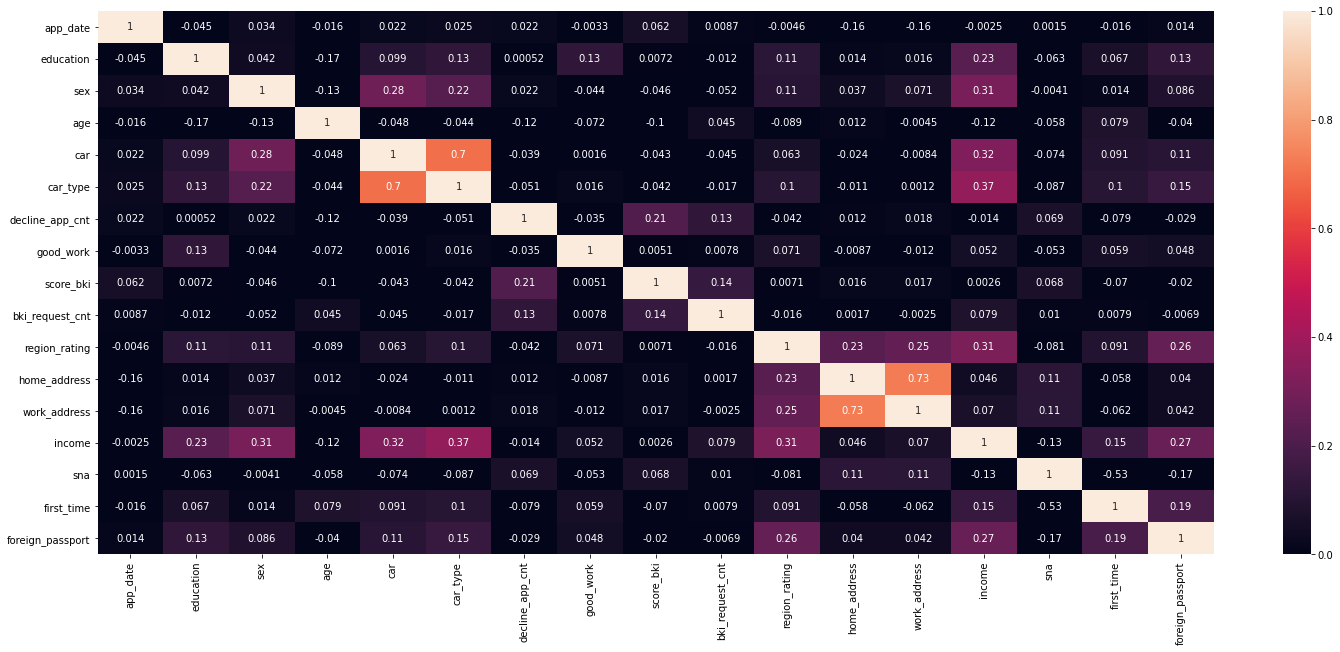

In [21]:
corr = data.drop(columns=['default', 'test']).corr()
fig, axes = plt.subplots(figsize=(25,10))
sns.heatmap(corr, ax=axes, vmin=0, vmax=1, annot = True)

Слишком высоких значений нет, хотя есть пары с довольно значимой корреляцией. Посмотрим на значимость (отдельно) численных и категоральных/бинарных переменных:

<AxesSubplot:>

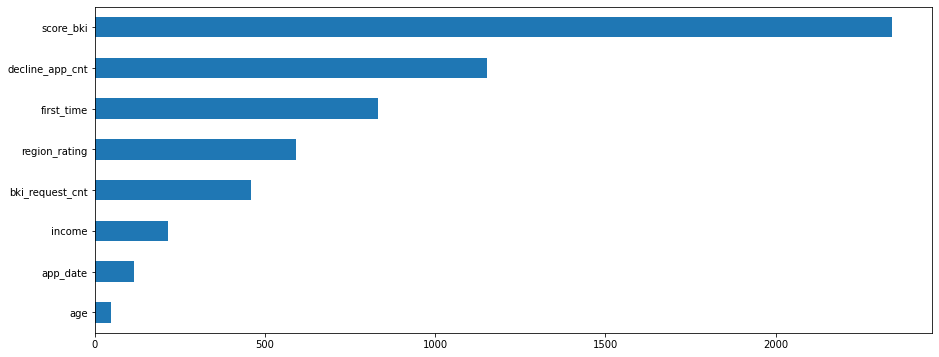

In [22]:
temp = data[data.test == 0]
inum = pd.Series(f_classif(temp[num_cols], temp['default'])[0], index = num_cols)
inum.sort_values(inplace = True)
inum.plot(kind = 'barh', figsize=(15,6))

<AxesSubplot:>

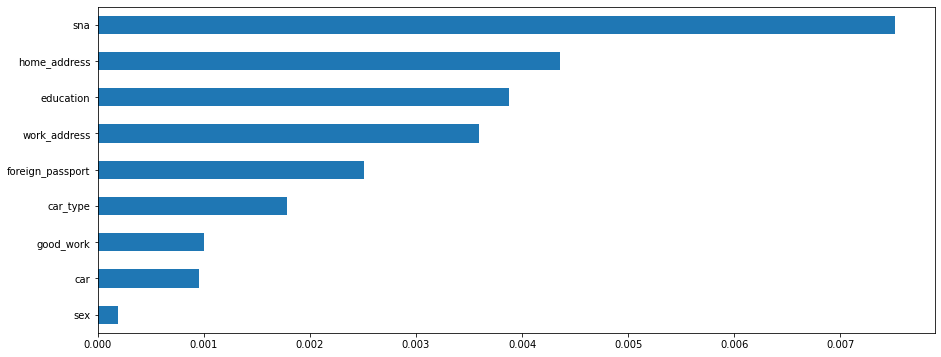

In [23]:
icat = pd.Series(mutual_info_classif(temp[bin_cols + cat_cols], temp['default'], discrete_features=True), index = bin_cols + cat_cols)
icat.sort_values(inplace = True)
icat.plot(kind = 'barh', figsize=(15,6))

Перед пробным обучением модели и последующим feature ingeneering необходимо снова разделить дата-сет на тренировочный и тестовый, т.к. данные из тестового дата-сета не должны повлиять на обучение модели.

In [24]:
train = data[data.test == 0].drop(columns='test')
test = data[data.test == 1].drop(columns=['default','test'])

Посколько будет несколько итераций обучения модели, необходимо сразу создать функцию. которая будет обучать модель и выводить ее метрики. 

In [25]:
def run_model(df):
    # get index of target column
    def_idx = list(df.columns).index('default')
    
    # use stratified split method because data aren't balanced
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RND_STATE)
    
    # get train and validation indicies
    train_indices, valid_indices = [split for split in sss.split(df.iloc[:, :def_idx], df.iloc[:, def_idx])][0]
    
    # finally - get train and validation X an y values
    df_train = df.iloc[train_indices]
    df_valid = df.iloc[valid_indices]
    X_train = df_train.drop(columns='default').values
    y_train = df_train.default.values
    X_valid = df_valid.drop(columns='default').values
    y_valid = df_valid.default.values
    
    # fit the model
    lr = LogisticRegression(max_iter = 1000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_valid)
    
    # show ROC AUC curve
    probs = lr.predict_proba(X_valid)
    probs = probs[:,1]

    fpr, tpr, threshold = roc_curve(y_valid, probs)
    roc_auc = roc_auc_score(y_valid, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
    print('f1_score:',f1_score(y_valid,y_pred))
    
    cm = confusion_matrix(y_valid, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['OK','Default'])
    cmd.plot()
    cmd.ax_.set(xlabel='Predicted', ylabel='True')

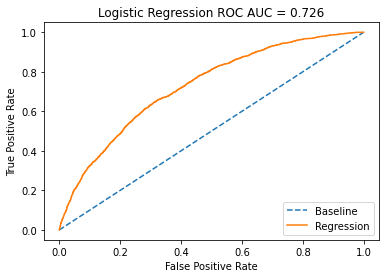

f1_score: 0.050505050505050504


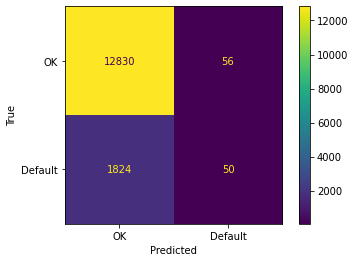

In [26]:
run_model(train)

F1 метрика на уровне плинтуса. Похоже, наша модель сейчас просто всем подряд одобряет кредиты. Попробуем это изменить

## Feature ingeneering

Попробуем улучшить значимость числовых столбцов, ассоциировав их с наиболее значимыми категоральными.

In [27]:
def mean_by_col(df, col_by, col_to):
    # compute mean values of 'col_to' column grouped by 'col_by'
    temp = df.groupby(by=col_by)[col_to].mean().to_dict()
    df[col_to + '_' + col_by] = df[col_by].map(temp)

In [28]:
def income_by_cat(df):
    # by 'sna'
    mean_by_col(df, 'sna', 'income')
    # by 'home_address'
    mean_by_col(df, 'home_address', 'income')    
    # by 'education'
    mean_by_col(df, 'education', 'income')
    

In [29]:
def income_by_num(df):
    # add temporary column
    df['bki2'] = 0.5 * np.round(df.score_bki / 0.5)
    # by 'score_bki'
    mean_by_col(df, 'bki2', 'income')
    # by 'region_rating'
    mean_by_col(df, 'region_rating', 'income')
    # remove temporary column
    df.drop(columns='bki2', inplace=True)

In [30]:
def prepare_model(df):
    income_by_cat(df)
    income_by_num(df)
    # normalize numeric columns
    global num_cols
    num_cols_final = num_cols + ['income_sna', 'income_home_address', 'income_education', 'income_bki2', 'income_region_rating']
    df[num_cols_final] = StandardScaler().fit_transform(df[num_cols_final])
    # translate categorial columns to dummies
    df = pd.get_dummies(df, columns=['home_address', 'work_address', 'sna'])    

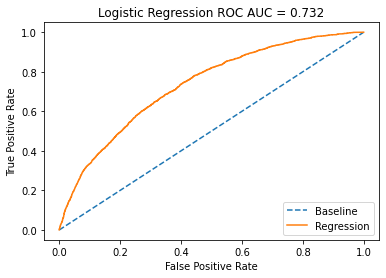

f1_score: 0.05138539042821159


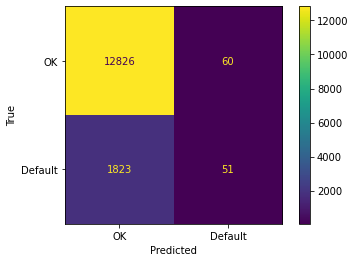

In [31]:
prepare_model(train)
run_model(train)

`ROC AUC` лучше, но в целом модель не улучшилась. Я считаю, что из-за изначальной несбалансированности выборки модель склонна любого клиента считать "положительным" просто потому что положительных в 7 раз больше в обучающей выборке. Проверить эту гипотезу можно с помощью `undersampling`-а

In [32]:
def undesample(df):
    # compute normal and default count
    def_cnt = df.default.value_counts()
    # take 95% of difference between them (to save some kind of imbalance)
    unb = int(0.95 * (def_cnt[0] - def_cnt[1]))
    indicies = df[df.default == 0].sample(unb, random_state=RND_STATE).index
    # and drop this amount of rows from non-default clients
    return df.drop(index=indicies)

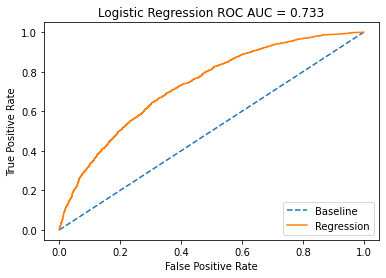

f1_score: 0.5968018275271273


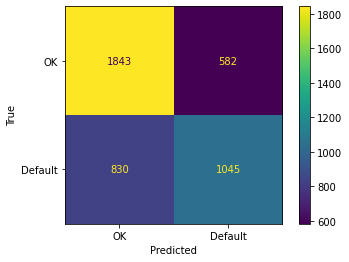

In [33]:
run_model(undesample(train))

Сильно лучше. Не только улчшили `ROC AUC`, но и `f1 score` теперь выглядит так, что вряд ли начальник будет смеяться над качеством модели больше часа. Попробуем поиграть в оптимизацию. в `sklearn` есть специальный класс для оптимизации логистической регрессии - `LogisticRegressionCV`, используем его. Он сам уже умеет в `Stratified K-fold`, надо всего лишь настроить пару параметров:

In [34]:
def optimize_model(df):
    X = df.drop(columns='default')
    y = df.default    
    # fit the model
    lrc = LogisticRegressionCV(cv=5, class_weight='balanced', max_iter = 1000, random_state=RND_STATE)
    lrc.fit(X, y)
    print('LogisticRegressionCV score:', lrc.score(X, y))
    return lrc

In [35]:
# run optimization on prepared dataset
lrc = optimize_model(train)

LogisticRegressionCV score: 0.6751310993373894


Вроде неплохая метрика. Попробуем сделать submission на ее основе.

In [36]:
prepare_model(test)
y_pred = lrc.predict_proba(test)

In [37]:
submis = pd.DataFrame(data={'client_id': test_client_id, 'default': y_pred[:,1]})


In [38]:
submis.to_csv('my_submission.csv', index=False)